In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import csv

import sklearn
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as imba_make_pipeline, Pipeline as ImbaPipeline
from joblib import dump, load

import spacy

In [2]:
np.random.seed(0)
spacy.util.fix_random_seed(0)

In [3]:
data = pd.read_csv("ai-ethics.tsv", sep="\t")
data

,fname,date,is_ai,is_ethics,title,description,is_ai %,is_ethics %,a_is_ai,l_is_ai,p_is_ai,a_is_ethics,l_is_ethics,p_is_ethics,clf_is_ethics,clf_is_ethics_prob
0,abs1705.03487,2017-05-06,1.0,0,A neural network system for transformation of ...,We propose a novel system which can transform ...,100.00%,0.00%,1.0,1.0,1.0,0.0,0,0.0,0,0.383240
1,abs1910.02390,2019-10-06,1.0,0,Migration through Machine Learning Lens -- Pre...,"In this paper, we have discussed initial findi...",100.00%,33.33%,1.0,1.0,1.0,0.0,1,0.0,0,0.379631
2,abs1405.1605,2014-05-07,1.0,0,DepecheMood: a Lexicon for Emotion Analysis fr...,While many lexica annotated with words polarit...,100.00%,33.33%,1.0,1.0,1.0,0.0,1,0.0,0,0.300291
3,abs1907.04534,2019-07-10,1.0,1,The Role of Cooperation in Responsible AI Deve...,"In this paper, we argue that competitive press...",100.00%,100.00%,1.0,1.0,1.0,1.0,1,1.0,1,0.733579
4,abs1906.04272,2019-06-10,1.0,1,Building High-Quality Auction Fraud Dataset,Given the magnitude of online auction transact...,100.00%,66.67%,1.0,1.0,1.0,1.0,1,0.0,1,0.592441
5,abs1707.06939,2017-07-21,1.0,0,Autocompletion interfaces make crowd workers s...,Creative tasks such as ideation or question pr...,100.00%,0.00%,1.0,1.0,1.0,0.0,0,0.0,0,0.287950
6,abs1810.02724,2018-10-02,1.0,1,Human Indignity: From Legal AI Personhood to S...,It is possible to rely on current corporate la...,100.00%,100.00%,1.0,1.0,1.0,1.0,1,1.0,1,0.710515
7,abs1904.05643,2019-04-11,1.0,0,Political Discussions in Homogeneous and Cross...,"Online platforms, such as Facebook, Twitter, a...",66.67%,33.33%,1.0,1.0,0.0,1.0,0,0.0,0,0.372337
8,abs1903.02706,2019-03-06,1.0,0,Twitter Speaks: A Case of National Disaster Si...,"In recent years, we have been faced with a ser...",66.67%,33.33%,1.0,0.0,1.0,0.0,1,0.0,0,0.287313
9,abs0901.3839,2009-01-24,1.0,0,Remembering what we like: Toward an agent-base...,Analysis of aggregate Web traffic has shown th...,66.67%,0.00%,1.0,1.0,0.0,0.0,0,0.0,0,0.332034


In [4]:
ai_index_ethics_keywords = [
    ['ethic'],
    ['ethics'],
    ['ethical'],
    ['moral'],
    ['morality'],
    ['sustainability'],
    ['racist'],
    ['racism'],
    ['machine', 'bias'],
    ['unemployment'],
    ['employment'],
    ['workforce'],
    ['humanity'],
    ['humane'],
    ['fool'],
    ['fooling'],
    ['fooled'],
    ['security'],
    ['secure'],
    ['sentient'],
    ['sentience'],
    ['rights'],
    ['law'],
    ['society'],
    ['responsibility'],
    ['accountability'],
    ['accountable'],
    ["privacy"],
]

In [5]:
def ai_index_is_ethics( text, kws ):
    qty = 0
    for kw in kws:
        has = True
        for k in kw:
            if k not in text:
                has = False
                break
            #end if
        #end for
        if has:
            qty += 1
        #end if
    return qty
#end check

In [6]:
ai_index_pred = []
for doc in data.description:
    ai_index_pred.append(ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0)
    
for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(data.is_ethics, ai_index_pred))

confusion_matrix [[986 131]
 [157 151]]
f1_score 0.511864406779661
precision_score 0.5354609929078015
recall_score 0.4902597402597403
accuracy_score 0.7978947368421052
roc_auc_score 0.6864906579544


In [7]:
human_labeled_data = data[data['is_ethics %'].notna()]

ai_index_pred = []
for doc in human_labeled_data.description:
    ai_index_pred.append(ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0)

for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(human_labeled_data.is_ethics, ai_index_pred))

confusion_matrix [[181  19]
 [ 49  41]]
f1_score 0.5466666666666666
precision_score 0.6833333333333333
recall_score 0.45555555555555555
accuracy_score 0.7655172413793103
roc_auc_score 0.6802777777777778


In [8]:
ai_index_pred = []
for doc in data.title:
    ai_index_pred.append(ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0)
    
for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(data.is_ethics, ai_index_pred))

confusion_matrix [[1082   35]
 [ 256   52]]
f1_score 0.26329113924050634
precision_score 0.5977011494252874
recall_score 0.16883116883116883
accuracy_score 0.7957894736842105
roc_auc_score 0.5687486193305352


In [9]:
human_labeled_data = data[data['is_ethics %'].notna()]

ai_index_pred = []
for doc in human_labeled_data.title:
    ai_index_pred.append(ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0)

for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(human_labeled_data.is_ethics, ai_index_pred))

confusion_matrix [[196   4]
 [ 77  13]]
f1_score 0.24299065420560748
precision_score 0.7647058823529411
recall_score 0.14444444444444443
accuracy_score 0.7206896551724138
roc_auc_score 0.5622222222222222


In [10]:
nlp = spacy.load("en_core_web_lg")

In [11]:
abstracts = []
for doc in nlp.pipe(data.description):
    abstracts.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))

titles = []
for doc in nlp.pipe(data.description):
    titles.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))

In [12]:
vectorizer = CountVectorizer(
    max_df = 0.75,
    max_features = None,
    min_df = 2,
)
X = vectorizer.fit_transform(abstracts+titles)
X_abs = vectorizer.transform(abstracts)
X_ttl = vectorizer.transform(titles)

In [13]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, list(data.is_ethics)+list(data.is_ethics))

In [14]:
lg_pipeline = Pipeline([
        ('tfidf', TfidfTransformer(
            norm = "l1",
            use_idf = True,
        )),
        ('clf', LogisticRegression(
            penalty = "l1",
            solver = "liblinear",
            C = 1,
        )),
    ])

cross_val_score(lg_pipeline, X_resampled, y_resampled, cv=4, scoring = "roc_auc", n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.0s finished


array([0.90827282, 0.91356915, 0.90923806, 0.90865996])

In [15]:
rf_pipeline = Pipeline([
        ('tfidf', TfidfTransformer(
            norm = "l1",
            use_idf = True,
        )),
        ('clf', RandomForestClassifier(
            max_depth = 8,
            n_estimators = 512,
        )),
    ])

cross_val_score(rf_pipeline, X_resampled, y_resampled, cv=4, scoring = "roc_auc", n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    3.1s finished


array([0.99572774, 0.99821109, 0.99641898, 0.99831708])

In [16]:
lg_pipeline = Pipeline([
        ('tfidf', TfidfTransformer(
            norm = "l1",
            use_idf = True,
        )),
        ('clf', LogisticRegression(
            penalty = "l1",
            solver = "liblinear",
            C = 1,
        )),
    ])

In [17]:
lg_pipeline.fit(X_resampled,y_resampled)

Pipeline(memory=None,
     steps=[('tfidf', TfidfTransformer(norm='l1', smooth_idf=True, sublinear_tf=False, use_idf=True)), ('clf', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [18]:
keywords_idx = [i for i,x in enumerate(lg_pipeline.named_steps["clf"].coef_[0,:]) if x>0]
antikeywords_idx = [i for i,x in enumerate(lg_pipeline.named_steps["clf"].coef_[0,:]) if x<0]
keywords_idx, antikeywords_idx, lg_pipeline.named_steps["clf"].intercept_

([632, 1235, 2802, 3390, 3613, 3617, 4428, 4445, 5537, 5682, 5984, 7018, 9368],
 [2441, 4794, 5779, 5933, 6163, 8741, 9706],
 array([-0.58851721]))

In [19]:
mapping = vectorizer.get_feature_names()

print([mapping[i] for i in keywords_idx])
print([mapping[i] for i in antikeywords_idx])

['ai', 'bias', 'discrimination', 'ethical', 'fair', 'fairness', 'how', 'human', 'machine', 'may', 'moral', 'portrait', 'trust']
['datum', 'information', 'method', 'model', 'network', 'student', 'use']


In [20]:
lemma_kws = set()
for kws in ai_index_ethics_keywords:
    kw = " ".join(kws)
    lemma_kws |= set(x.lemma_ for x in nlp(kw))
print(lemma_kws)

{'accountability', 'ethic', 'unemployment', 'morality', 'racism', 'security', 'sentient', 'employment', 'sustainability', 'bias', 'workforce', 'humanity', 'privacy', 'racist', 'society', 'ethical', 'moral', 'humane', 'right', 'responsibility', 'accountable', 'law', 'secure', 'sentience', 'fool', 'machine'}


In [21]:
rf_pipeline = Pipeline([
        ('tfidf', TfidfTransformer(
            norm = "l1",
            use_idf = False,
        )),
        ('clf', RandomForestClassifier(
            max_depth = 8,
            n_estimators = 512,
        )),
    ])

In [22]:
rf_pipeline.fit(X_resampled,y_resampled)

Pipeline(memory=None,
     steps=[('tfidf', TfidfTransformer(norm='l1', smooth_idf=True, sublinear_tf=False,
         use_idf=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, mi...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [23]:
X_title = vectorizer.transform([" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct) for doc in nlp.pipe(data.title)])

y_pred = rf_pipeline.predict(X_title)
y_prob = rf_pipeline.predict_proba(X_title)

In [24]:
print(""" Trained only on abstracts:
confusion_matrix [[1043   74]
 [ 130  178]]
f1_score 0.6357142857142858
precision_score 0.7063492063492064
recall_score 0.577922077922078
accuracy_score 0.8568421052631578
roc_auc_score 0.7558365984955062
""")

 Trained only on abstracts:
confusion_matrix [[1043   74]
 [ 130  178]]
f1_score 0.6357142857142858
precision_score 0.7063492063492064
recall_score 0.577922077922078
accuracy_score 0.8568421052631578
roc_auc_score 0.7558365984955062



In [25]:
for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(data.is_ethics, y_pred))

confusion_matrix [[1043   74]
 [ 124  184]]
f1_score 0.6501766784452297
precision_score 0.7131782945736435
recall_score 0.5974025974025974
accuracy_score 0.8610526315789474
roc_auc_score 0.765576858235766


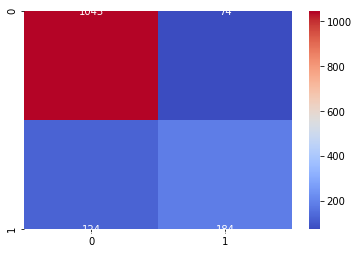

In [26]:
sns.heatmap(confusion_matrix(data.is_ethics, y_pred), annot=True, fmt="d", cmap="coolwarm")

In [27]:
X_title = vectorizer.transform([" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct) for doc in nlp.pipe(human_labeled_data.title)])

y_pred = rf_pipeline.predict(X_title)
y_prob = rf_pipeline.predict_proba(X_title)

for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(human_labeled_data.is_ethics, y_pred))

confusion_matrix [[190  10]
 [ 46  44]]
f1_score 0.611111111111111
precision_score 0.8148148148148148
recall_score 0.4888888888888889
accuracy_score 0.8068965517241379
roc_auc_score 0.7194444444444444


In [28]:
dump(rf_pipeline, "rf_pipeline_saved.joblib")

['rf_pipeline_saved.joblib']

In [29]:
rf_pipeline_loaded = load("rf_pipeline_saved.joblib")

In [30]:
X_title = vectorizer.transform([" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct) for doc in nlp.pipe(human_labeled_data.title)])

y_pred = rf_pipeline_loaded.predict(X_title)
y_prob = rf_pipeline_loaded.predict_proba(X_title)

for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(human_labeled_data.is_ethics, y_pred))

confusion_matrix [[190  10]
 [ 46  44]]
f1_score 0.611111111111111
precision_score 0.8148148148148148
recall_score 0.4888888888888889
accuracy_score 0.8068965517241379
roc_auc_score 0.7194444444444444


In [31]:
aaai_data = pd.read_csv("aaai.txt", sep=";", quotechar="#", header=0, names=["year","id","title","authors","link","abstract"])
aaai_data = aaai_data[aaai_data["abstract"].notna()]

In [32]:
aaai_docs = []
for doc in nlp.pipe(aaai_data.abstract):
    aaai_docs.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))

In [33]:
aaai_X = vectorizer.transform(aaai_docs)
aaai_y_pred = rf_pipeline.predict(aaai_X)
aaai_y_prob = rf_pipeline.predict_proba(aaai_X)

In [34]:
aaai_data["is_ethics_with_ai"] = aaai_y_pred

In [35]:
aaai_ai_index_pred = []
for doc in aaai_data.abstract:
    aaai_ai_index_pred.append(1 if ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0 else 0)

In [36]:
aaai_data["is_ethics_ai_index"] = aaai_ai_index_pred

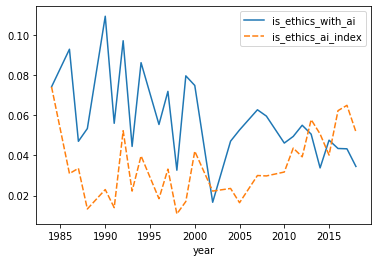

In [37]:
sns.lineplot(data=aaai_data[["year","is_ethics_with_ai","is_ethics_ai_index"]].groupby("year").mean())

In [38]:
nips_data = pd.read_csv("nips.txt", sep=";", quotechar="#", header=0, names=["year","id","title","authors","link","abstract"])
nips_data = nips_data[nips_data["abstract"].notna()]

In [39]:
nips_docs = []
for doc in nlp.pipe(nips_data.abstract):
    nips_docs.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))

In [40]:
nips_X = vectorizer.transform(nips_docs)
nips_y_pred = rf_pipeline.predict(nips_X)
nips_y_prob = rf_pipeline.predict_proba(nips_X)

In [41]:
nips_data["is_ethics_with_ai"] = nips_y_pred

In [42]:
nips_ai_index_pred = []
for doc in nips_data.abstract:
    nips_ai_index_pred.append(1 if ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0 else 0)

In [43]:
nips_data["is_ethics_ai_index"] = nips_ai_index_pred

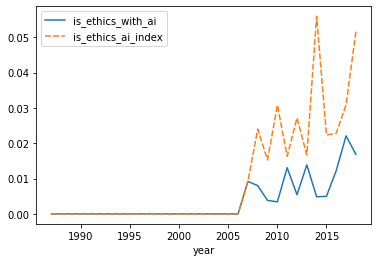

In [44]:
sns.lineplot(data=nips_data[["year","is_ethics_with_ai","is_ethics_ai_index"]].groupby("year").mean())

In [45]:
aaai_data["conf"] = "aaai"
nips_data["conf"] = "nips"

In [46]:
a = aaai_data[["year","is_ethics_with_ai","is_ethics_ai_index"]].groupby("year").mean()
n = nips_data[["year","is_ethics_with_ai","is_ethics_ai_index"]].groupby("year").mean()

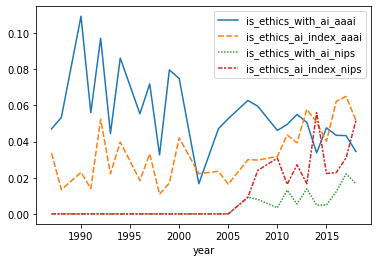

In [47]:
sns.lineplot(data=pd.merge(a,n, on="year", suffixes=("_aaai","_nips")))

In [48]:
cdblp = pd.read_csv("cdblp.csv", sep="\t", quotechar='"', header=1, names=["key","title","booktitle","year","ee","empty"]).drop("empty", axis=1)

In [49]:
def ai_conf(v):
    return v.upper() in ["AAAI","IJCAI","NIPS","ICML"]

def robotics_conf(v):
    return v.upper() in ["ICRA","IROS"]

In [50]:
cdblp["conftype"] = None
cdblp["conftype"][cdblp.booktitle.apply(ai_conf)] = "AI"
cdblp["conftype"][cdblp.booktitle.apply(robotics_conf)] = "Robotics"
cdblp["conftype"][cdblp["conftype"].isna()] = cdblp.booktitle[cdblp["conftype"].isna()]

C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [51]:
filtered_cdblp = cdblp[np.logical_or(cdblp.conftype=="AI",cdblp.conftype=="Robotics")]
filtered_cdblp = filtered_cdblp[filtered_cdblp.title.notna()]

In [52]:
cdblp_docs = []
for doc in nlp.pipe(filtered_cdblp.title):
    cdblp_docs.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))
cdblp_y_pred = rf_pipeline.predict(vectorizer.transform(cdblp_docs))

cdblp_ai_index_pred = []
for doc in filtered_cdblp.title:
    cdblp_ai_index_pred.append(1 if ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0 else 0)

In [53]:
filtered_cdblp["is_ethics_with_ai"] = cdblp_y_pred
filtered_cdblp["is_ethics_ai_index"] = cdblp_ai_index_pred

In [54]:
list(filtered_cdblp[np.logical_and(filtered_cdblp.year==2000, filtered_cdblp.booktitle=="AAAI")].title)

['An ILP Method Based on Instance Graph.',
 'Artificial Intelligence-Based Computer Modeling Tools for Controlling Slag Foaming in Electric Furnaces.',
 'Mixed-Initiative Reasoning for Integrated Domain Modeling, Learning and Problem Solving.',
 'Ontology Integration in XML.']

In [55]:
cdf = filtered_cdblp[["year","booktitle","is_ethics_with_ai", "is_ethics_ai_index"]].groupby(["year","booktitle"]).mean().reset_index()

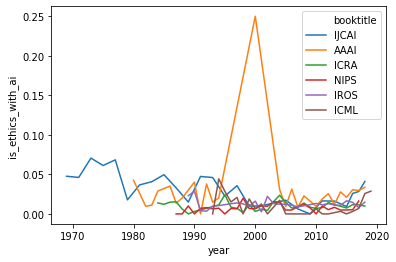

In [56]:
sns.lineplot(data=cdf, x="year", y="is_ethics_with_ai", hue="booktitle")

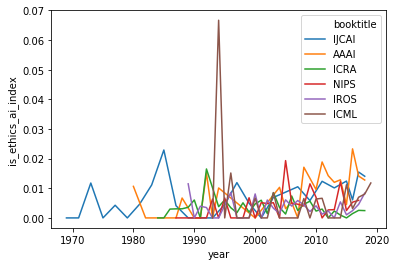

In [57]:
sns.lineplot(data=cdf, x="year", y="is_ethics_ai_index", hue="booktitle")

(-0.0125, 0.2625)

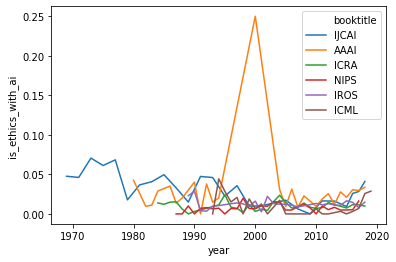

In [58]:
f, ax1 = plt.subplots()
sns.lineplot(data=cdf, x="year", y="is_ethics_with_ai", hue="booktitle", ax=ax1)
ylim = ax1.get_ylim()
ax1.set_yticks(ax1.get_yticks())
ax1.set_ylim(ylim)

(-0.0125, 0.2625)

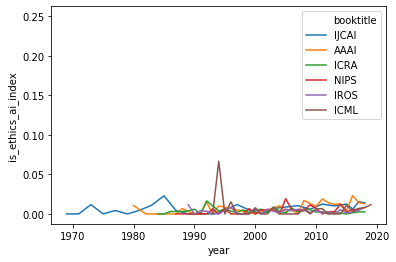

In [59]:
f, ax2 = plt.subplots()
sns.lineplot(data=cdf, x="year", y="is_ethics_ai_index", hue="booktitle", ax=ax2)
ax2.set_yticks(ax1.get_yticks())
ax2.set_ylim(ylim)

In [60]:
cdf.to_csv("conference.csv")

In [61]:
years = sorted(list(set(map(int,cdf.year))))
confs = sorted(list(set(cdf.booktitle)))
values = {}
for i in cdf.index:
    y = int(cdf.year[i])
    conf = cdf.booktitle[i]
    values[(y,conf)] = cdf.is_ethics_with_ai[i]

print("year".format(y),end="")
for c in confs:
    print(" & {}".format(c),end="")
print("\\\\")
for y in years:
    print("{}".format(y),end="")
    for c in confs:
        if (y,c) in values:
            val = "{:.3f}".format(values[(y,c)])
        else:
            val = "-"
        print(" & {}".format(val),end="")
    print("\\\\")

year & AAAI & ICML & ICRA & IJCAI & IROS & NIPS\\
1969 & - & - & - & 0.048 & - & -\\
1971 & - & - & - & 0.046 & - & -\\
1973 & - & - & - & 0.071 & - & -\\
1975 & - & - & - & 0.061 & - & -\\
1977 & - & - & - & 0.068 & - & -\\
1979 & - & - & - & 0.018 & - & -\\
1980 & 0.043 & - & - & - & - & -\\
1981 & - & - & - & 0.037 & - & -\\
1982 & 0.010 & - & - & - & - & -\\
1983 & 0.011 & - & - & 0.041 & - & -\\
1984 & 0.029 & - & 0.014 & - & - & -\\
1985 & - & - & 0.012 & 0.050 & - & -\\
1986 & 0.035 & - & 0.015 & - & - & -\\
1987 & 0.014 & - & 0.015 & 0.033 & - & 0.000\\
1988 & 0.020 & - & 0.006 & - & - & 0.000\\
1989 & - & - & 0.000 & 0.015 & 0.023 & 0.010\\
1990 & 0.040 & - & 0.003 & - & 0.029 & 0.000\\
1991 & 0.000 & - & 0.005 & 0.047 & 0.004 & 0.007\\
1992 & 0.038 & - & 0.007 & - & 0.003 & 0.008\\
1993 & 0.015 & 0.000 & - & 0.046 & 0.010 & 0.006\\
1994 & 0.020 & 0.044 & 0.011 & - & 0.011 & 0.007\\
1995 & - & 0.029 & 0.024 & 0.023 & - & 0.000\\
1996 & - & 0.015 & 0.009 & - & 0.013 & 0.007\\
1

In [62]:
jdblp = pd.read_csv("jdblp.csv", sep="\t", quotechar='"', header=1, names=["key","title","journal","volume","year","ee","empty"]).drop("empty", axis=1)

C:\Users\Pedro\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [63]:
def infix_of(v,confs):
    return any(c.lower() in v.lower()  for c in confs)

def ieee_trans_ai(v):
    confs = ["IEEE Trans. Affective", "IEEE Trans. Audio, Speech", "IEEE Trans.Cognitive", "IEEE Trans. Comput. Intellig.", "IEEE Trans.Emerging Topics in Comput. Intellig", "IEEE Trans. Fuzzy Systems", "IEEE Trans. Intelligent", "IEEE Trans. Neural"]
    return infix_of(v,confs)

def ieee_trans_robotics(v):
    confs = ["IEEE Trans. Automat.", "IEEE Trans. Automation", "IEEE Trans. Robotics"]
    return infix_of(v,confs)

def ieee_trans(v):
    confs = ["IEEE Trans."]
    return infix_of(v,confs)

def acm_trans(v):
    confs = ["ACM Trans."]
    return infix_of(v,confs)


In [64]:
jdblp["journaltype"] = None
jdblp["journaltype"][jdblp.journal.apply(ieee_trans)] = "IEEE Trans."
jdblp["journaltype"][jdblp.journal.apply(ieee_trans_ai)] = "IEEE Trans. (AI)"
jdblp["journaltype"][jdblp.journal.apply(ieee_trans_robotics)] = "IEEE Trans. Robotics"
jdblp["journaltype"][jdblp.journal.apply(acm_trans)] = "ACM Trans."
jdblp["journaltype"][jdblp.journal=="J. Artif. Intell. Res."] = "J. Artif. Intell. Res."
jdblp["journaltype"][jdblp.journal=="IEEE Computer"] = "IEEE Computer"

C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Pedro\Anaconda3\lib\

In [65]:
filtered_jdblp = jdblp[jdblp.journaltype.notna()]
filtered_jdblp = filtered_jdblp[filtered_jdblp.title.notna()]

In [66]:
jdblp_docs = []
for doc in nlp.pipe(filtered_jdblp.title):
    jdblp_docs.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))
jdblp_y_pred = rf_pipeline.predict(vectorizer.transform(jdblp_docs))

jdblp_ai_index_pred = []
for doc in filtered_jdblp.title:
    jdblp_ai_index_pred.append(1 if ai_index_is_ethics(doc.lower(), ai_index_ethics_keywords)>0 else 0)

In [67]:
filtered_jdblp["is_ethics_with_ai"] = jdblp_y_pred
filtered_jdblp["is_ethics_ai_index"] = jdblp_ai_index_pred

In [68]:
filtered_jdblp[np.logical_and(filtered_jdblp.is_ethics_with_ai,np.logical_and(filtered_jdblp.journaltype=="IEEE Computer", filtered_jdblp.year==2011))]

,key,title,journal,volume,year,ee,journaltype,is_ethics_with_ai,is_ethics_ai_index
223177,journals/computer/KrugerSO11,How Computing Will Change the Face of Retail.,IEEE Computer,44,2011,https://doi.org/10.1109/MC.2011.112,IEEE Computer,1,0
223194,journals/computer/Bowyer11,What Surprises Do Identical Twins Have for Ide...,IEEE Computer,44,2011,https://doi.org/10.1109/MC.2011.221,IEEE Computer,1,0
223267,journals/computer/KuikkaniemiJTHM11,From Space to Stage: How Interactive Screens W...,IEEE Computer,44,2011,https://doi.org/10.1109/MC.2011.135,IEEE Computer,1,0
224599,journals/computer/RicanekB11,What Are Soft Biometrics and How Can They Be U...,IEEE Computer,44,2011,https://doi.org/10.1109/MC.2011.296,IEEE Computer,1,0


In [69]:
jdf = filtered_jdblp[["year","journaltype","is_ethics_with_ai", "is_ethics_ai_index"]].groupby(["year","journaltype"]).mean().reset_index()

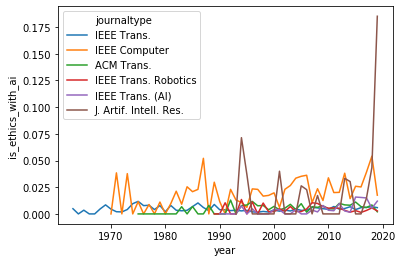

In [70]:
sns.lineplot(data=jdf, x="year", y="is_ethics_with_ai", hue="journaltype")

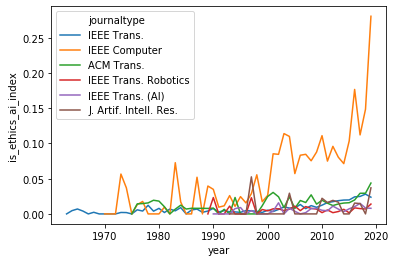

In [71]:
sns.lineplot(data=jdf, x="year", y="is_ethics_ai_index", hue="journaltype")

(-0.014035087719298246, 0.29473684210526313)

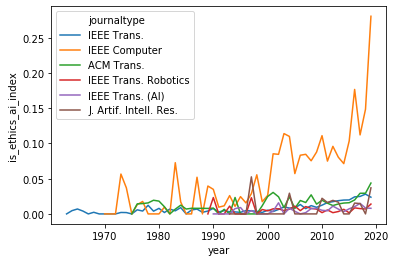

In [72]:
f, ax1 = plt.subplots()
sns.lineplot(data=jdf, x="year", y="is_ethics_ai_index", hue="journaltype", ax=ax1)
ylim = ax1.get_ylim()
ax1.set_yticks(ax1.get_yticks())
ax1.set_ylim(ylim)

(-0.014035087719298246, 0.29473684210526313)

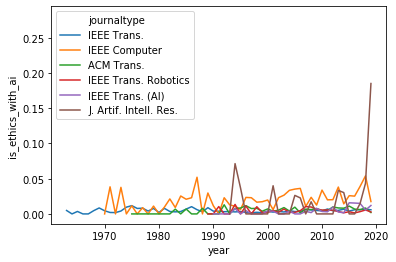

In [73]:
f, ax2 = plt.subplots()
sns.lineplot(data=jdf, x="year", y="is_ethics_with_ai", hue="journaltype", ax=ax2)
ax2.set_yticks(ax1.get_yticks())
ax2.set_ylim(ylim)

In [74]:
years = sorted(list(set(map(int,jdf.year))))
confs = sorted(list(set(jdf.journaltype)))
values = {}
for i in jdf.index:
    y = int(jdf.year[i])
    conf = jdf.journaltype[i]
    values[(y,conf)] = jdf.is_ethics_with_ai[i]

print("year".format(y),end="")
for c in confs:
    print(" & {}".format(c),end="")
print("\\\\")
for y in years:
    print("{}".format(y),end="")
    for c in confs:
        if (y,c) in values:
            val = "{:.3f}".format(values[(y,c)])
        else:
            val = "-"
        print(" & {}".format(val),end="")
    print("\\\\")


year & ACM Trans. & IEEE Computer & IEEE Trans. & IEEE Trans. (AI) & IEEE Trans. Robotics & J. Artif. Intell. Res.\\
1963 & - & - & 0.005 & - & - & -\\
1964 & - & - & 0.000 & - & - & -\\
1965 & - & - & 0.003 & - & - & -\\
1966 & - & - & 0.000 & - & - & -\\
1967 & - & - & 0.000 & - & - & -\\
1968 & - & - & 0.005 & - & - & -\\
1969 & - & - & 0.008 & - & - & -\\
1970 & - & 0.000 & 0.004 & - & - & -\\
1971 & - & 0.038 & 0.002 & - & - & -\\
1972 & - & 0.000 & 0.002 & - & - & -\\
1973 & - & 0.038 & 0.004 & - & - & -\\
1974 & - & 0.000 & 0.010 & - & - & -\\
1975 & 0.000 & 0.011 & 0.012 & - & - & -\\
1976 & 0.000 & 0.000 & 0.008 & - & - & -\\
1977 & 0.000 & 0.009 & 0.008 & - & - & -\\
1978 & 0.000 & 0.000 & 0.004 & - & - & -\\
1979 & 0.000 & 0.011 & 0.008 & - & - & -\\
1980 & 0.000 & 0.000 & 0.002 & - & - & -\\
1981 & 0.000 & 0.010 & 0.008 & - & - & -\\
1982 & 0.000 & 0.021 & 0.003 & - & - & -\\
1983 & 0.007 & 0.009 & 0.003 & - & - & -\\
1984 & 0.000 & 0.025 & 0.003 & - & - & -\\
1985 & 0.007 

In [75]:
jdf.to_csv("journal.csv")

In [76]:
random_5_disagreements_journals = np.random.choice(
    filtered_jdblp[filtered_jdblp.is_ethics_with_ai != filtered_jdblp.is_ethics_ai_index].index,
    5,
    False
)

random_5_disagreements_conferences = np.random.choice(
    filtered_cdblp[filtered_cdblp.is_ethics_with_ai != filtered_cdblp.is_ethics_ai_index].index,
    5,
    False
)

In [77]:
filtered_jdblp.loc[random_5_disagreements_journals]

,key,title,journal,volume,year,ee,journaltype,is_ethics_with_ai,is_ethics_ai_index
75969,journals/twc/HeCCB12,Secure and Efficient Handover Authentication B...,IEEE Trans. Wireless Communications,11,2012,https://doi.org/10.1109/TWC.2011.110811.111240,IEEE Trans.,0,1
4294,journals/tifs/CaiCZYY14,When Does Relay Transmission Give a More Secur...,IEEE Trans. Information Forensics and Security,9,2014,https://doi.org/10.1109/TIFS.2013.2297835,IEEE Trans.,0,1
179917,journals/taffco/RavajaBKST18,Virtual Character Facial Expressions Influence...,IEEE Trans. Affective Computing,9,2018,https://doi.org/10.1109/TAFFC.2016.2601101,IEEE Trans. (AI),1,0
147232,journals/tit/Kendall65,Performance of the biased square-law sequentia...,IEEE Trans. Information Theory,11,1965,https://doi.org/10.1109/TIT.1965.1053724,IEEE Trans.,0,1
234451,journals/tocs/ZdancewicZNM02,Secure program partitioning.,ACM Trans. Comput. Syst.,20,2002,https://doi.org/10.1145/566340.566343,ACM Trans.,0,1


In [79]:
filtered_jdblp.loc[random_5_disagreements_journals].title.values

array(['Secure and Efficient Handover Authentication Based on Bilinear Pairing Functions.',
       'When Does Relay Transmission Give a More Secure Connection in Wireless Ad Hoc Networks?',
       'Virtual Character Facial Expressions Influence Human Brain and Facial EMG Activity in a Decision-Making Game.',
       'Performance of the biased square-law sequential detector in the absence of signal.',
       'Secure program partitioning.'], dtype=object)

In [78]:
filtered_cdblp.loc[random_5_disagreements_conferences]

,key,title,booktitle,year,ee,conftype,is_ethics_with_ai,is_ethics_ai_index
19122,conf/icra/MayerBKBLB08,Human-machine skill transfer extended by a sca...,ICRA,2008.0,https://doi.org/10.1109/ROBOT.2008.4543644,Robotics,1,0
58884,conf/iros/ChoiCLS09,Enhanced manipulator's safety with artificial ...,IROS,2009.0,https://doi.org/10.1109/IROS.2009.5353904,Robotics,1,0
75216,conf/ijcai/KwokFN03,Coherence of Laws.,IJCAI,2003.0,http://ijcai.org/Proceedings/03/Papers/216.pdf,AI,0,1
36650,conf/nips/AvidanB06,Efficient Methods for Privacy Preserving Face ...,NIPS,2006.0,http://papers.nips.cc/paper/3081-efficient-met...,AI,0,1
71976,conf/ijcai/Kowalski91,Logic Programing in Artificial Intelligence.,IJCAI,1991.0,http://ijcai.org/Proceedings/91-1/Papers/090.pdf,AI,1,0


In [80]:
filtered_cdblp.loc[random_5_disagreements_conferences].title.values

array(['Human-machine skill transfer extended by a scaffolding framework.',
       "Enhanced manipulator's safety with artificial pneumatic muscle.",
       'Coherence of Laws.',
       'Efficient Methods for Privacy Preserving Face Detection.',
       'Logic Programing in Artificial Intelligence.'], dtype=object)

In [86]:
filtered_cdblp[np.logical_and(filtered_cdblp.year==2000, filtered_cdblp.booktitle=="AAAI")]

,key,title,booktitle,year,ee,conftype,is_ethics_with_ai,is_ethics_ai_index
23169,conf/aaai/Zhang00a,An ILP Method Based on Instance Graph.,AAAI,2000.0,http://www.aaai.org/Library/AAAI/2000/aaai00-1...,AI,0,0
25017,conf/aaai/Wilson00,Artificial Intelligence-Based Computer Modelin...,AAAI,2000.0,http://www.aaai.org/Library/AAAI/2000/aaai00-1...,AI,1,0
25614,conf/aaai/BoicuT00,Mixed-Initiative Reasoning for Integrated Doma...,AAAI,2000.0,http://www.aaai.org/Library/AAAI/2000/aaai00-1...,AI,0,0
28648,conf/aaai/JeongH00a,Ontology Integration in XML.,AAAI,2000.0,http://www.aaai.org/Library/AAAI/2000/aaai00-1...,AI,0,0


In [100]:
filtered_jdblp[np.logical_and(np.logical_and(filtered_jdblp.year==2019, filtered_jdblp.journaltype.str.startswith("IEEE C")),np.logical_or(filtered_jdblp.is_ethics_ai_index,filtered_jdblp.is_ethics_with_ai))].title.values

array(['Codes of Ethics in a Post-Truth World.',
       'Accredited Undergraduate Cybersecurity Degrees: Four Approaches.',
       'The 2019 IEEE Computer Society: Targeting Member Satisfaction and Technical Excellence.',
       'Educating Future Multidisciplinary Cybersecurity Teams.',
       'Learning to Live in an Insecure World.',
       'Computer Security as Civil Defense.',
       'Seeding Cybersecurity Workforce Pathways With Secondary Education.',
       'Privacy Decision Making: The Brain Approach.',
       'Curricular Foundations for Cybersecurity.',
       'Security and Privacy in the Internet of Things.',
       'Computer Highlights Society Magazines.',
       'Evolving From Know-How to Know-What.',
       'Cybersecurity Curricula 2017 and Boeing: Linking Curricular Guidance to Professional Practice.',
       'Computer Highlights Society Magazines.',
       'Educational and Workforce Cybersecurity Frameworks: Comparing, Contrasting, and Mapping.',
       'Algorithms: Law an

In [101]:
filtered_jdblp[np.logical_and(np.logical_and(filtered_jdblp.year==2019, filtered_jdblp.journaltype.str.startswith("J. A")),np.logical_or(filtered_jdblp.is_ethics_ai_index,filtered_jdblp.is_ethics_with_ai))].title.values

array(["AI Generality and Spearman's Law of Diminishing Returns.",
       'Iterative Local Voting for Collective Decision-making in Continuous Spaces.',
       'Fair Allocation of Indivisible Goods to Asymmetric Agents.',
       'Viewpoint: Human-in-the-loop Artificial Intelligence.',
       'On Overfitting and Asymptotic Bias in Batch Reinforcement Learning with Partial Observability.'],
      dtype=object)